### 问题 1
该物流网络包括 57 个分拣中心，每个分拣中心过去 4个月的每天货量如附件 1所示，过去 30 天的每小时货量如附件 2 所示。建立货量预测模型，对57个分拣中心未来30天每天及每小时的货量进行预测，将预测结果写入结果表1和表2中。


### 第一部分：对57个分拣中心未来30天的货量进行预测

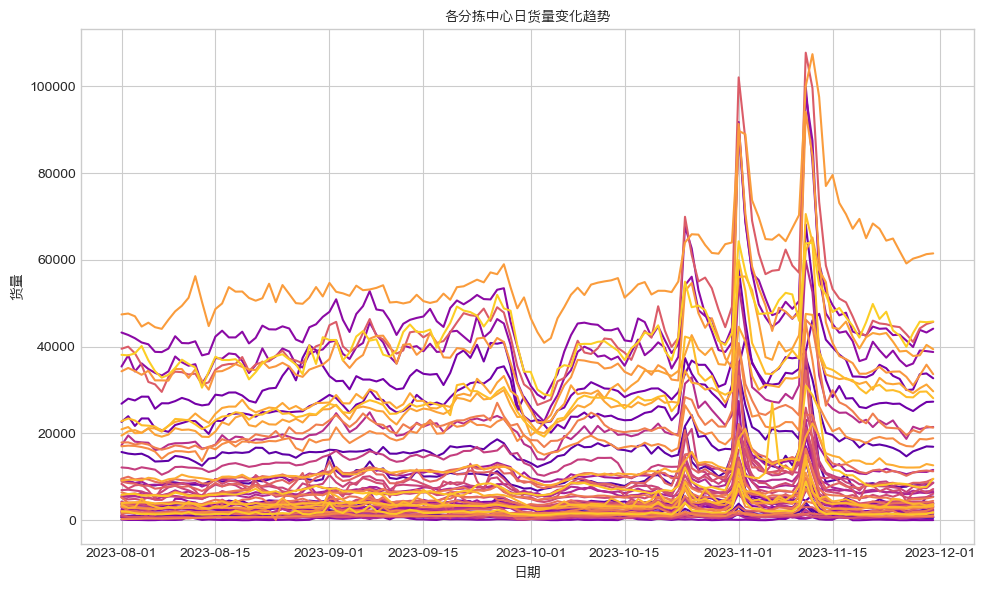

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties

data_daily = pd.read_csv('附件1.csv')
data_daily['日期'] = pd.to_datetime(data_daily['日期'])
data_daily.set_index('日期', inplace=True)

font_path = '/System/Library/Fonts/PingFang.ttc'
my_font = FontProperties(fname=font_path)

# 准备颜色数组，用于图表中区分不同的分拣中心
colors = plt.cm.plasma(np.linspace(0.1, 0.9, len(data_daily['分拣中心'].unique())))


plt.figure(figsize=(10, 6))

# 遍历每个分拣中心进行绘图
for center, color in zip(data_daily['分拣中心'].unique(), colors):
    center_data = data_daily[data_daily['分拣中心'] == center]['货量'].sort_index()
    plt.plot(center_data, color=color)

plt.title('各分拣中心日货量变化趋势', fontproperties=my_font)
plt.xlabel('日期', fontproperties=my_font)
plt.ylabel('货量', fontproperties=my_font)
plt.tight_layout()

plt.show()


### 图片分析：
总货量变化呈现季节性模式。说明季节性ARIMA模型（SARIMA）是较好的选择，进一步绘制XXX图片验证季节性趋势

处理中心：SC28


/var/folders/ng/h1_4zcsj2qq895j6xpxvjyqh0000gn/T/ipykernel_10572/3033155409.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


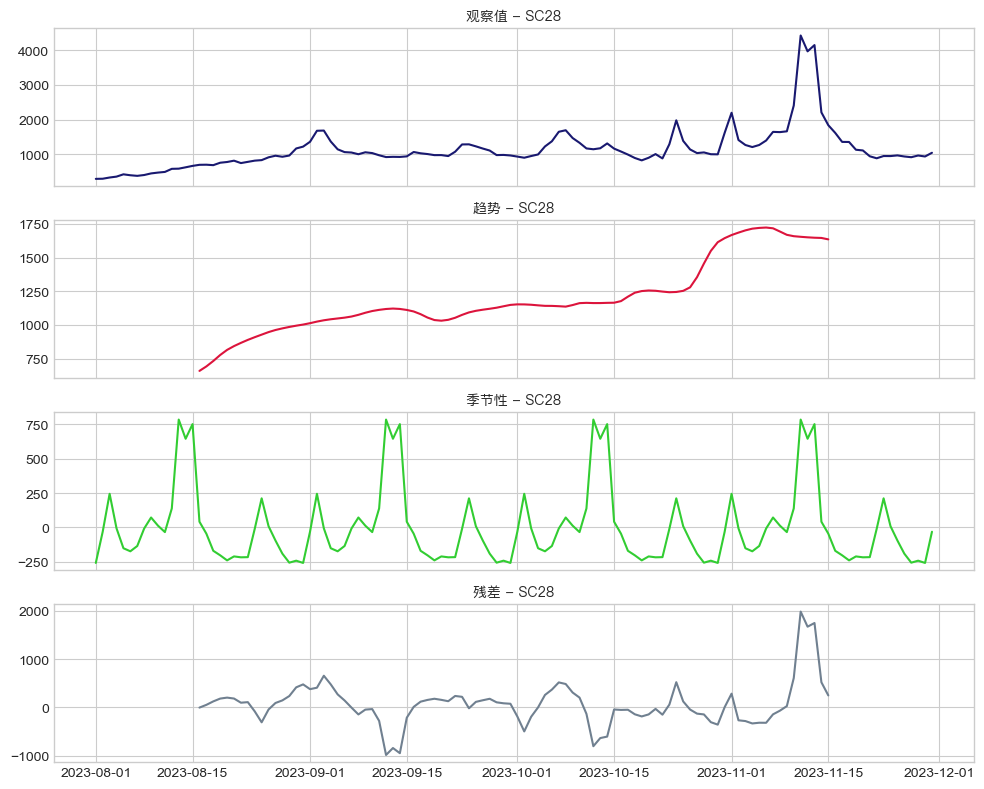

In [71]:
from statsmodels.tsa.seasonal import seasonal_decompose

font_path = '/System/Library/Fonts/PingFang.ttc'
my_font = FontProperties(fname=font_path)

centers = ['SC28'] # 以SC28中心为例

# 进行季节性分解
for center in centers:
    print(f"处理中心：{center}")
    center_data = data_daily[data_daily['分拣中心'] == center]['货量'].sort_index()

    # 检查数据量是否足够进行季节性分解
    if len(center_data) < 50:
        print(f"{center}的数据量不足，无法进行季节性分解。")
        continue

    # 季节性分解
    decompose_result = seasonal_decompose(center_data, model='additive', period=30)
    
plt.style.use('seaborn-whitegrid')

fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
axs[0].plot(decompose_result.observed, color='midnightblue')  # 深蓝色突出观察值
axs[0].set_title(f'观察值 - {center}', fontproperties=my_font)
axs[1].plot(decompose_result.trend, color='crimson')  # 深红色强调趋势
axs[1].set_title(f'趋势 - {center}', fontproperties=my_font)
axs[2].plot(decompose_result.seasonal, color='limegreen')  # 鲜绿色表示季节性
axs[2].set_title(f'季节性 - {center}', fontproperties=my_font)
axs[3].plot(decompose_result.resid, color='slategrey')  # 石板灰处理残差
axs[3].set_title(f'残差 - {center}', fontproperties=my_font)

# 设置布局并显示图形
plt.tight_layout()
plt.show()



### 图片分析：说明绘制了哪个分拣中心的货量数据的XX图片以进行季节性分析，从以下三点出发进行分析：

1. 季节性成分的规律性...
2. 周期的一致性...
3. 残差的相对稳定性...
综上所述，分拣中心的货量数据显示出了规律性的季节性波动。


### 这段代码的执行步骤如下：

1. **确定日期范围**：获取数据集中的最新日期，以便计算未来30天的日期序列。
3. **分拣中心数据处理**：对数据集中的每个唯一分拣中心，提取对应的货量数据，并按日期排序。
4. **模型训练**：
   - 使用auto_arima自动寻找最优的季节性ARIMA模型参数。
   - 确定ARIMA模型的非季节性和季节性组分的阶数(p, d, q)和(P, D, Q)，以及周期性长度(m)。
5. **存储最优参数**
6. **预测未来货量**

### 数学原理包括：

- **ARIMA模型**
  - **AR(p)**
  - **I(d)**
  - **MA(q)**
- **季节性ARIMA(SARIMA)**
- **参数选择**：auto_arima函数自动执行参数选择过程，通过网格搜索和AIC(赤池信息准则)评估多个模型，并选择最佳模型。


In [39]:
from pmdarima import auto_arima

# 获取最新的日期，以便生成预测日期序列
latest_date = data_daily.index.max()

forecast_results = []

optimal_params = {}

# 遍历每个分拣中心
for center in data_daily['分拣中心'].unique():
    print(f"Processing center: {center}")
    center_data = data_daily[data_daily['分拣中心'] == center]['货量'].sort_index()

    # 使用auto_arima自动寻找最优SARIMA模型参数
    model = auto_arima(center_data, seasonal=True, m=12, trace=True,
                       error_action='ignore', suppress_warnings=True,
                       stepwise=True)

    # 存储最优模型参数
    optimal_params[center] = model.get_params()

    # 生成未来30天的日期序列
    future_dates = pd.date_range(start=latest_date + pd.Timedelta(days=1), periods=30)
    
    # 预测未来30天的货量
    future_forecast = model.predict(n_periods=30).round(0).astype(int)
    
    forecast_df = pd.DataFrame({
        '分拣中心': center,
        '日期': future_dates,
        '货量': future_forecast
    })
    
    forecast_results.append(forecast_df)

params_df = pd.DataFrame.from_dict(optimal_params, orient='index')
params_df.to_csv('最优参数1.csv')

final_forecast = pd.concat(forecast_results)

final_forecast['日期'] = final_forecast['日期'].dt.strftime('%Y/%m/%d')

final_forecast.to_csv('结果1.csv', index=False)

print("The optimal parameters and forecast results have been saved to CSV files.")

Processing center: SC48
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1802.442, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1797.930, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1795.514, Time=0.04 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1795.285, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2002.868, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1794.086, Time=0.03 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1796.191, Time=0.04 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=1797.280, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1796.249, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=1796.063, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1794.244, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=1798.054, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12]             : AIC=1928.943, Time=0.01 sec

Best model:  ARIMA(0,0,1)(0,0,0)[12] intercept
Total fit time

### 第二部分：对57个分拣中心未来30天每小时的货量进行预测

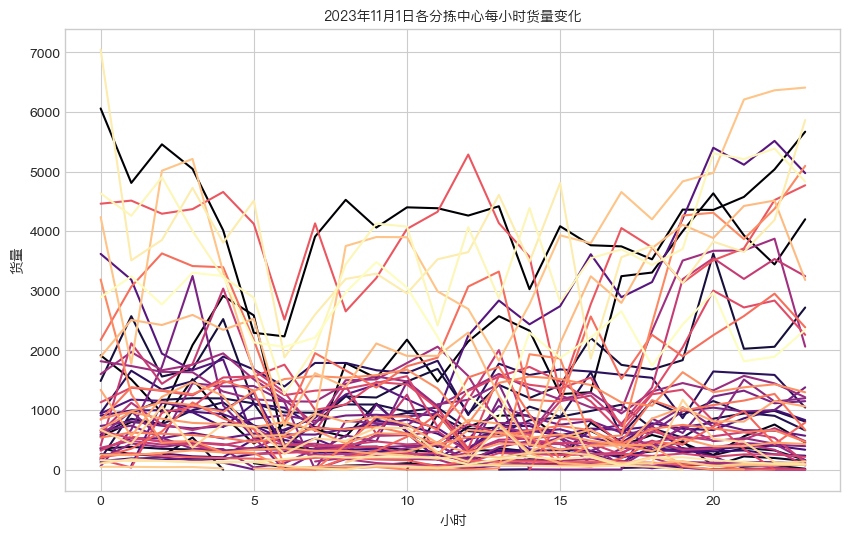

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

font_path = '/System/Library/Fonts/PingFang.ttc'
my_font = FontProperties(fname=font_path)

file_path = '附件2.csv'
data = pd.read_csv(file_path)
data['日期'] = pd.to_datetime(data['日期'])
data_sorted = data.sort_values(by=['分拣中心', '日期', '小时'])

data_specific_date = data_sorted[data_sorted['日期'] == '2023-11-01']
pivot_table_specific_date = data_specific_date.pivot(index='小时', columns='分拣中心', values='货量')

color_cycle = plt.cm.magma(np.linspace(0, 1, len(pivot_table_specific_date.columns)))

plt.figure(figsize=(10, 6))
for i, center in enumerate(pivot_table_specific_date.columns):
    plt.plot(pivot_table_specific_date.index, pivot_table_specific_date[center], color=color_cycle[i])

plt.title('2023年11月1日各分拣中心每小时货量变化', fontproperties=my_font)
plt.xlabel('小时', fontproperties=my_font)
plt.ylabel('货量', fontproperties=my_font)
plt.grid(True)
plt.show()


数学原理与第一部分相同，执行过程也基本一致，不同的在于第二部分需要：将日期和小时合并成单个的时间戳，并将其设置为数据框架的索引，以便于时间序列分析。

In [52]:
data['日期'] = pd.to_datetime(data['日期'])
sorted_data = data.sort_values(by=['日期', '小时'])
data = sorted_data

In [58]:
from pmdarima import auto_arima

sorted_data = pd.read_csv('sorted_data.csv')
sorted_data['日期'] = pd.to_datetime(sorted_data['日期'])

# 将日期和小时合并为一个时间戳
sorted_data['timestamp'] = sorted_data.apply(lambda row: row['日期'].replace(hour=int(row['小时'])), axis=1)
sorted_data.set_index('timestamp', inplace=True)

# 获取最新的日期和小时，以便生成预测日期和小时序列
latest_timestamp = sorted_data.index.max()

forecast_results = []

optimal_params = {}

# 遍历每个分拣中心
for center in sorted_data['分拣中心'].unique():
    print(f"Processing center: {center}")
    # 筛选当前分拣中心的数据并且按时间戳排序
    center_data = sorted_data[sorted_data['分拣中心'] == center]['货量'].sort_index()

    # 使用auto_arima自动寻找最优SARIMA模型参数，开启并行计算
    model = auto_arima(center_data, seasonal=True, m=24, trace=True,
                       error_action='ignore', suppress_warnings=True,
                       stepwise=True, n_jobs=-1,
                       start_p=1, start_q=1, max_p=2, max_q=2,
                       start_P=0, start_Q=0, max_P=1, max_Q=1)

    # 存储最优模型参数
    optimal_params[center] = model.get_params()

    # 生成未来30天的日期和小时序列
    future_timestamps = pd.date_range(start=latest_timestamp + pd.Timedelta(hours=1), periods=30*24, freq='H')
    
    # 预测未来30天的货量
    future_forecast = model.predict(n_periods=30*24).round(0).astype(int)
    
    forecast_df = pd.DataFrame({
        '分拣中心': center,
        '日期': [ts.strftime('%Y/%m/%d') for ts in future_timestamps],
        '小时': [ts.hour for ts in future_timestamps],
        '货量': future_forecast
    })
    
    forecast_results.append(forecast_df)

params_df = pd.DataFrame.from_dict(optimal_params, orient='index')
params_df.to_csv('最优参数2.csv')

final_forecast = pd.concat(forecast_results)

final_forecast.to_csv('结果2.csv', index=False)

print("The optimal parameters and forecast results have been saved to CSV files.")


Processing center: SC54
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=10140.060, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=10262.072, Time=0.01 sec


/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=9746.680, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=10260.073, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=10165.405, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=9254.507, Time=1.93 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=9355.983, Time=0.78 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=9337.750, Time=1.65 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=9242.736, Time=3.74 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=inf, Time=1.87 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=inf, Time=2.13 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=9373.919, Time=3.63 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=3.43 sec
 ARIMA(0,1,2)(1,0,1)[24] intercept   : AIC=9239.541, Time=3.78 sec
 ARIMA(0,1,2)(0,0,1)[24] intercept   : AIC=9743.211, Time=0.82 sec
 ARIMA(0,1,2)(1,0,0

/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=6987.540, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=6931.401, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=7030.906, Time=0.01 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=6881.761, Time=1.15 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=6881.651, Time=0.97 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=1.87 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=6929.535, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=6986.648, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=6882.397, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[24] intercept   : AIC=6882.396, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[24] intercept   : AIC=6887.849, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[24] intercept   : AIC=6957.550, Time=0.01 sec
 ARIMA(2,1,2)(0,0,0)[24] intercept   : AIC=6883.878, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[24]             : AIC=6878.713, Time=0.03 sec
 ARIMA(1,1,1)(1,0,0)[24]             : AIC=6880.033, Time=0.38 sec


/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=9504.744, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=9498.538, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=9517.847, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=9498.573, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=9500.520, Time=0.64 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=9498.599, Time=0.22 sec
 ARIMA(0,1,0)(0,0,1)[24] intercept   : AIC=9520.437, Time=0.14 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(0,1,2)(0,0,1)[24] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=9504.710, Time=0.17 sec
 ARIMA(1,1,2)(0,0,1)[24] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(0,1,1)(0,0,1)[24]             : AIC=9496.513, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[24]             : AIC=9496.547, Time=0.01 sec
 ARIMA(0,1,1)(1,0,1)[24]             : AIC=9498.499, Time=0.37 sec
 ARIMA(0,1,1)(1,0,0)[24]             : AIC=9496.571, Time=0.11 sec
 ARIMA(0,1

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=3994.271, Time=0.52 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=3977.356, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=4630.768, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=3980.654, Time=0.03 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=3979.255, Time=0.37 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=3977.569, Time=0.53 sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=4044.371, Time=0.25 sec
 ARIMA(1,0,1)(0,0,1)[24] intercept   : AIC=3978.714, Time=0.67 sec
 ARIMA(0,0,2)(0,0,1)[24] intercept   : AIC=3978.673, Time=0.53 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=3994.054, Time=0.28 sec
 ARIMA(1,0,2)(0,0,1)[24] intercept   : AIC=3980.542, Time=0.52 sec
 ARIMA(0,0,1)(0,0,1)[24]             : AIC=4282.085, Time=0.23 sec

Best model:  ARIMA(0,0,1)(0,0,1)[24] intercept
Total fit time: 4.388 seconds
Processing center: SC68
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=inf, Tim

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=7346.703, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=7486.632, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=7346.123, Time=0.02 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=7346.109, Time=0.18 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=7345.866, Time=0.63 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=7489.852, Time=0.35 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=7265.955, Time=0.46 sec
 ARIMA(2,1,0)(0,0,1)[24] intercept   : AIC=7265.041, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[24] intercept   : AIC=7263.520, Time=0.03 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=7265.158, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[24]             : AIC=7261.520, Time=0.01 sec
 ARIMA(2,1,0)(1,0,0)[24]             : AIC=7263.159, Time=0.08 sec
 ARIMA(2,1,0)(0,0,1)[24]             : AIC=7263.042, Time=0.10 sec
 ARIM

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=10297.650, Time=0.71 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=10293.281, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=10366.851, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=10347.446, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=10217.013, Time=1.59 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=10215.540, Time=0.88 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=10354.470, Time=0.43 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(0,1,2)(1,0,0)[24] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(1,1,2)(1,0,0)[24] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(0,1,1)(1,0,0)[24]             : AIC=10213.850, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[24]             : AIC=10345.443, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[24]             : AIC=10215.279, Time=1.44 sec
 ARIMA(0,1,1)(0,0,1)[24]             : AIC=10291.281, Time=0.50 sec
 ARIMA(0,1,0)(1,0,0)[24]             : AIC=10352.502, Time=0.08 se

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=11955.038, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=13794.974, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=12444.678, Time=0.10 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=11864.883, Time=1.85 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=11407.357, Time=1.44 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(1,0,1)(1,0,0)[24] intercept   : AIC=11429.961, Time=1.74 sec
 ARIMA(0,0,2)(1,0,0)[24] intercept   : AIC=11376.059, Time=1.51 sec
 ARIMA(0,0,2)(0,0,0)[24] intercept   : AIC=12327.683, Time=0.11 sec
 ARIMA(0,0,2)(1,0,1)[24] intercept   : AIC=11772.755, Time=2.67 sec
 ARIMA(0,0,2)(0,0,1)[24] intercept   : AIC=11872.318, Time=1.08 sec
 ARIMA(1,0,2)(1,0,0)[24] intercept   : AIC=inf, Time=2.09 sec
 ARIMA(0,0,2)(1,0,0)[24]             : AIC=11401.427, Time=0.93 sec

Best model:  ARIMA(0,0,2)(1,0,0)[24] intercept
Total fit time: 16

/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=11885.808, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=11324.883, Time=0.72 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=11589.502, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=11883.825, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=11887.081, Time=0.01 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=2.34 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=11605.038, Time=0.62 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=11363.720, Time=0.55 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=11240.205, Time=1.10 sec
 ARIMA(2,1,0)(0,0,0)[24] intercept   : AIC=11814.980, Time=0.05 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=11066.052, Time=2.63 sec
 ARIMA(2,1,0)(0,0,1)[24] intercept   : AIC=11535.708, Time=0.91 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=3.53 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=2.57 sec
 ARI

/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=9301.117, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=9082.235, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=9429.381, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=9081.036, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=9082.200, Time=0.65 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=2.03 sec
 ARIMA(0,1,2)(0,0,0)[24] intercept   : AIC=9082.458, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=9299.617, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[24] intercept   : AIC=9084.380, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[24]             : AIC=9079.092, Time=0.02 sec
 ARIMA(0,1,1)(1,0,0)[24]             : AIC=9080.255, Time=1.03 sec
 ARIMA(0,1,1)(0,0,1)[24]             : AIC=9080.291, Time=0.83 sec
 ARIMA(0,1,1)(1,0,1)[24]             : AIC=inf, Time=1.30 sec
 ARIMA(1,1,1)(0,0,0)[24]             : AIC=9080.588, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[24]             : AIC=9080.518, Time=0.07 sec
 ARIM

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=10006.937, Time=0.79 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=10054.249, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=10351.984, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=10330.157, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=9953.818, Time=1.52 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=10135.021, Time=0.76 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=10105.282, Time=1.18 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=9865.367, Time=2.94 sec
 ARIMA(2,1,0)(0,0,1)[24] intercept   : AIC=10090.069, Time=0.88 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=9922.173, Time=1.33 sec
 ARIMA(2,1,0)(0,0,0)[24] intercept   : AIC=10296.300, Time=0.04 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=9717.124, Time=3.02 sec
 ARIMA(2,1,1)(0,0,1)[24] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=9793.954, Time=2.50 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=inf, Time=0.22 s

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=10552.561, Time=0.81 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=10747.929, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=10972.328, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=10966.285, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=10774.106, Time=0.62 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=10704.394, Time=0.54 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=10490.909, Time=1.43 sec
 ARIMA(2,1,0)(0,0,0)[24] intercept   : AIC=10947.441, Time=0.03 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=3.43 sec
 ARIMA(2,1,0)(0,0,1)[24] intercept   : AIC=10754.840, Time=0.89 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=inf, Time=1.65 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=10440.577, Time=1.53 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=2.66 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(0,1

/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=11154.477, Time=1.10 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=12778.187, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=11623.212, Time=0.07 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=10889.123, Time=1.92 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=10400.594, Time=1.26 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(1,0,1)(1,0,0)[24] intercept   : AIC=inf, Time=1.46 sec
 ARIMA(0,0,2)(1,0,0)[24] intercept   : AIC=10385.602, Time=1.62 sec
 ARIMA(0,0,2)(0,0,0)[24] intercept   : AIC=11524.115, Time=0.13 sec
 ARIMA(0,0,2)(1,0,1)[24] intercept   : AIC=10897.267, Time=2.30 sec
 ARIMA(0,0,2)(0,0,1)[24] intercept   : AIC=11103.531, Time=1.70 sec
 ARIMA(1,0,2)(1,0,0)[24] intercept   : AIC=inf, Time=1.99 sec
 ARIMA(0,0,2)(1,0,0)[24]             : AIC=10411.678, Time=1.36 sec

Best model:  ARIMA(0,0,2)(1,0,0)[24] intercept
Total fit time: 17.596 s

/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=11529.355, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=12057.240, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=11944.455, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=10894.879, Time=2.70 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=11045.205, Time=1.02 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=2.47 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=11114.396, Time=2.93 sec
 ARIMA(0,1,2)(1,0,1)[24] intercept   : AIC=10879.163, Time=2.62 sec
 ARIMA(0,1,2)(0,0,1)[24] intercept   : AIC=11528.339, Time=1.10 sec
 ARIMA(0,1,2)(1,0,0)[24] intercept   : AIC=11036.977, Time=1.85 sec
 ARIMA(0,1,2)(0,0,0)[24] intercept   : AIC=11903.976, Time=0.06 sec
 ARIMA(1,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=3.99 sec
 ARIMA(0,1,2)(1,0,1)[24]             : AIC=inf, Time=2.10 sec

Best model:  ARIMA(0,1,2)(1,0,1)[24] intercept
Total fit time: 22.536 s

/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=7208.970, Time=0.42 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=7154.694, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=7247.320, Time=0.01 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=7082.864, Time=0.76 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=7082.388, Time=1.45 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=7080.400, Time=1.01 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=7207.487, Time=0.45 sec
 ARIMA(2,1,1)(0,0,1)[24] intercept   : AIC=7066.257, Time=1.47 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=7085.082, Time=0.14 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=7068.256, Time=2.08 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=7068.650, Time=0.98 sec
 ARIMA(2,1,0)(0,0,1)[24] intercept   : AIC=7160.007, Time=0.50 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=7067.755, Time=1.77 sec
 ARIMA(1,1,2)(0,0,1)[24] intercept   : AIC=7067.233, Time=1.17 sec
 ARIMA(2,1,1)(0,0,1)[24]             : AIC=7064.714, Time=0.60

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=11111.285, Time=1.18 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=11375.391, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=11688.424, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=11686.879, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=11097.935, Time=1.15 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=11370.612, Time=0.68 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=11208.950, Time=0.96 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=11078.079, Time=1.89 sec
 ARIMA(2,1,0)(0,0,1)[24] intercept   : AIC=11369.355, Time=0.78 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(2,1,0)(0,0,0)[24] intercept   : AIC=11671.236, Time=0.04 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=3.25 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=11039.805, Time=2.65 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=inf, Time=2.11 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=11056.710, Time=1.81 se

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=7261.527, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=7198.420, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=7384.518, Time=0.01 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=7191.995, Time=0.81 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=7191.645, Time=1.61 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=7190.304, Time=1.11 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=7260.021, Time=0.21 sec
 ARIMA(2,1,1)(0,0,1)[24] intercept   : AIC=7185.651, Time=1.10 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=7193.370, Time=0.10 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=7186.980, Time=1.59 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=7187.276, Time=1.03 sec
 ARIMA(2,1,0)(0,0,1)[24] intercept   : AIC=7238.257, Time=0.21 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=7187.644, Time=1.35 sec
 ARIMA(1,1,2)(0,0,1)[24] intercept   : AIC=7186.945, Time=1.14 sec
 ARIMA(2,1,1)(0,0,1)[24]             : AIC=7184.356, Time=0.50

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=6699.354, Time=0.29 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=6698.755, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=7117.172, Time=0.01 sec
 ARIMA(1,0,1)(1,0,0)[24] intercept   : AIC=6696.250, Time=1.52 sec
 ARIMA(1,0,1)(0,0,1)[24] intercept   : AIC=6695.946, Time=0.72 sec
 ARIMA(1,0,1)(1,0,1)[24] intercept   : AIC=6697.142, Time=1.10 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=6697.181, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=6697.611, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[24] intercept   : AIC=6673.504, Time=0.04 sec
 ARIMA(2,0,1)(1,0,0)[24] intercept   : AIC=6674.673, Time=0.69 sec
 ARIMA(2,0,1)(0,0,1)[24] intercept   : AIC=6675.024, Time=0.40 sec
 ARIMA(2,0,1)(1,0,1)[24] intercept   : AIC=6676.283, Time=1.11 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=6671.227, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=6672.953, Time=0.32 sec
 ARIMA(2,0,0)(0,0,1)[24] intercept   : AIC=6672.736, Time=0.28

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=7195.447, Time=0.57 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=7133.711, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=7352.373, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=7164.424, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=7053.649, Time=0.91 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=7124.750, Time=0.58 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=7258.607, Time=0.67 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=7049.923, Time=1.29 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=7130.507, Time=0.93 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=7122.024, Time=0.85 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=7131.959, Time=1.06 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=7048.707, Time=1.70 sec
 ARIMA(2,1,1)(0,0,1)[24] intercept   : AIC=7124.227, Time=1.21 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=7116.798, Time=1.11 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=7152.382, Time=0.17

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=5963.867, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=5900.023, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=5969.613, Time=0.01 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=5842.617, Time=0.89 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=5842.575, Time=1.02 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=1.56 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=5898.540, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=5962.658, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=5819.211, Time=0.17 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=5819.298, Time=1.21 sec
 ARIMA(2,1,1)(0,0,1)[24] intercept   : AIC=5819.147, Time=1.33 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=2.22 sec
 ARIMA(2,1,0)(0,0,1)[24] intercept   : AIC=5934.502, Time=0.26 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=5812.104, Time=1.42 sec
 ARIMA(2,1,2)(0,0,0)[24] intercept   : AIC=5811.588, Time=0.17 sec
 ARIM

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Processing center: SC39
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=6837.852, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=6993.951, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=6970.596, Time=0.24 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=6902.467, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=6991.958, Time=0.01 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=6838.156, Time=0.91 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=6838.012, Time=1.00 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=6839.116, Time=1.50 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=6902.022, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=6970.038, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=6831.352, Time=0.11 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=6831.893, Time=1.25 sec
 ARIMA(2,1,1)(0,0,1)[24] intercept   : AIC=6831.726, Time=1.15 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=6832.600, Time=2.05

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Processing center: SC25
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=11514.596, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=12675.117, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=11608.076, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=13360.794, Time=0.01 sec
 ARIMA(1,0,1)(1,0,0)[24] intercept   : AIC=10952.995, Time=1.64 sec
 ARIMA(1,0,1)(1,0,1)[24] intercept   : AIC=10904.892, Time=2.23 sec
 ARIMA(1,0,1)(0,0,1)[24] intercept   : AIC=11281.169, Time=1.54 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=11481.882, Time=2.60 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=10802.114, Time=2.23 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=11306.188, Time=0.86 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=11586.608, Time=0.02 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=11286.295, Time=1.70 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=10939.212, T

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=1.67 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=11478.887, Time=1.65 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=13035.742, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=11933.135, Time=0.07 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=11274.110, Time=2.25 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=10713.834, Time=1.65 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(1,0,1)(1,0,0)[24] intercept   : AIC=inf, Time=1.92 sec
 ARIMA(0,0,2)(1,0,0)[24] intercept   : AIC=10721.619, Time=1.61 sec
 ARIMA(1,0,2)(1,0,0)[24] intercept   : AIC=inf, Time=3.39 sec
 ARIMA(0,0,1)(1,0,0)[24]             : AIC=10735.634, Time=0.54 sec

Best model:  ARIMA(0,0,1)(1,0,0)[24] intercept
Total fit time: 15.811 seconds
Processing center: SC18
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=8385.734, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=8672.102, Time=0.01 

/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=8549.888, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=8383.749, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=8670.116, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=8389.217, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=8370.107, Time=1.12 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=8384.167, Time=0.55 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=8675.602, Time=0.67 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=2.15 sec
 ARIMA(0,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=8538.936, Time=0.58 sec
 ARIMA(1,1,2)(1,0,1)[24] intercept   : AIC=8360.004, Time=2.62 sec
 ARIMA(1,1,2)(0,0,1)[24] intercept   : AIC=8375.065, Time=1.37 sec
 ARIMA(1,1,2)(1,0,0)[24] intercept   : AIC=8375.631, Time=1.12 sec
 ARIMA(1,1,2)(0,0,0)[24] intercept   : AIC=8380.406, Time=0.16 sec
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=2.63 sec
 ARIMA(2,1

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=11087.575, Time=1.12 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=11321.488, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=11607.219, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=11606.605, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=11070.507, Time=1.00 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=11322.233, Time=0.73 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=11105.072, Time=1.15 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=11053.116, Time=2.05 sec
 ARIMA(2,1,0)(0,0,1)[24] intercept   : AIC=11317.600, Time=0.96 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=11067.600, Time=1.33 sec
 ARIMA(2,1,0)(0,0,0)[24] intercept   : AIC=11606.409, Time=0.03 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=3.08 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=10956.278, Time=2.52 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=inf, Time=1.30 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=inf, Time=1.67 se

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=7486.843, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=7446.138, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=7521.655, Time=0.01 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=inf, Time=1.70 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=inf, Time=1.27 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=1.94 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=7444.341, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=7485.223, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[24] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[24] intercept   : AIC=7415.335, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[24] intercept   : AIC=7456.915, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[24] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[24]             : AIC=7383.510, Time=0.04 sec
 ARIMA(1,1,1)(1,0,0)[24]             : AIC=7385.271, Time=0.61 sec
 ARIMA(1,1,1)(0,0,1)[24] 

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=8251.904, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=8309.198, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=8303.507, Time=0.29 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=8301.098, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=8307.246, Time=0.01 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=8246.838, Time=1.24 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=2.42 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=8247.780, Time=1.34 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=8299.909, Time=0.18 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=8242.763, Time=1.51 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=8247.204, Time=0.19 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=2.63 sec
 ARIMA(2,1,1)(0,0,1)[24] intercept   : AIC=8243.608, Time=1.68 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=8267.934, Time=0.75 sec
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=8225.519, Time=2.28 sec
 ARIM

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=8974.581, Time=0.35 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=9130.934, Time=1.03 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=9972.875, Time=0.01 sec
 ARIMA(1,0,1)(1,0,0)[24] intercept   : AIC=8934.494, Time=0.35 sec
 ARIMA(1,0,1)(0,0,1)[24] intercept   : AIC=8934.849, Time=0.36 sec
 ARIMA(1,0,1)(1,0,1)[24] intercept   : AIC=8935.617, Time=0.56 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=9130.477, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=8972.629, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[24] intercept   : AIC=8881.068, Time=0.18 sec
 ARIMA(2,0,1)(1,0,0)[24] intercept   : AIC=8881.465, Time=2.02 sec
 ARIMA(2,0,1)(0,0,1)[24] intercept   : AIC=8870.638, Time=1.92 sec
 ARIMA(2,0,1)(1,0,1)[24] intercept   : AIC=inf, Time=2.04 sec
 ARIMA(2,0,0)(0,0,1)[24] intercept   : AIC=8904.150, Time=0.22 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=8869.653, Time=0.83 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=8871.970, Time=0.05 sec


/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=7161.077, Time=0.47 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=7102.312, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=7227.223, Time=0.01 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=7037.776, Time=0.87 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=7038.713, Time=1.26 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=7039.067, Time=0.89 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=7100.541, Time=0.46 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=7038.954, Time=1.22 sec
 ARIMA(1,1,2)(1,0,0)[24] intercept   : AIC=7038.919, Time=1.33 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=7224.211, Time=0.35 sec
 ARIMA(0,1,2)(1,0,0)[24] intercept   : AIC=7053.287, Time=0.92 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=7131.246, Time=0.62 sec
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=7030.226, Time=1.13 sec
 ARIMA(2,1,2)(0,0,0)[24] intercept   : AIC=7044.327, Time=0.11 sec
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=7031.888, Time=1.42

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=4278.262, Time=0.33 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=4267.234, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=4274.316, Time=0.01 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=4200.216, Time=1.23 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=4206.220, Time=0.64 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=4266.020, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=4276.324, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=4169.418, Time=0.06 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=4167.217, Time=0.92 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=4168.964, Time=1.79 sec
 ARIMA(2,1,1)(0,0,1)[24] intercept   : AIC=4167.058, Time=0.69 sec
 ARIMA(2,1,0)(0,0,1)[24] intercept   : AIC=4223.805, Time=0.23 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=4169.015, Time=0.96 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=4278.265, Time=0.55 sec


/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=11494.337, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=10931.105, Time=1.17 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=11232.395, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=11492.345, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=11496.229, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=2.81 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=11236.123, Time=0.73 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=10972.024, Time=0.50 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=1.92 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=10779.476, Time=1.90 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=1.95 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=inf, Time=1.76 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=10822.712, Time=1.51 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=10772.914, Time=2.57 sec
 ARIMA(2,1

/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=6843.943, Time=0.43 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=6751.048, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=6880.146, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=6758.745, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=6752.969, Time=0.81 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=6751.432, Time=0.57 sec
 ARIMA(0,1,0)(0,0,1)[24] intercept   : AIC=6872.921, Time=0.41 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=6689.628, Time=1.18 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=6691.506, Time=1.43 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=6689.857, Time=0.97 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=6844.450, Time=0.39 sec
 ARIMA(2,1,1)(0,0,1)[24] intercept   : AIC=6681.379, Time=1.10 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=6690.772, Time=0.09 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=6683.270, Time=1.59 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=6681.852, Time=1.33

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=7345.807, Time=0.42 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=7238.502, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=7415.827, Time=0.01 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=7210.158, Time=1.02 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=7212.095, Time=1.89 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=7210.481, Time=1.06 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=7238.422, Time=0.64 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=7211.207, Time=1.41 sec
 ARIMA(1,1,2)(1,0,0)[24] intercept   : AIC=7210.533, Time=1.30 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=7404.737, Time=0.25 sec
 ARIMA(0,1,2)(1,0,0)[24] intercept   : AIC=7208.612, Time=0.99 sec
 ARIMA(0,1,2)(0,0,0)[24] intercept   : AIC=7216.410, Time=0.07 sec
 ARIMA(0,1,2)(1,0,1)[24] intercept   : AIC=7210.606, Time=1.08 sec
 ARIMA(0,1,2)(0,0,1)[24] intercept   : AIC=7208.875, Time=0.71 sec
 ARIMA(0,1,2)(1,0,0)[24]             : AIC=7206.936, Time=0.28

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=9324.950, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=9748.562, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=9718.717, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=8923.548, Time=1.85 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=8953.504, Time=0.73 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=8990.784, Time=0.91 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=8909.143, Time=3.72 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=inf, Time=1.78 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=8949.746, Time=1.70 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=7.13 sec
 ARIMA(1,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=3.48 sec
 ARIMA(0,1,2)(1,0,1)[24] intercept   : AIC=8907.182, Time=2.38 sec
 ARIMA(0,1,2)(0,0,1)[24] intercept   : AIC=9295.812, Time=0.76 sec
 ARIMA(0,1,2)(1,0,0)

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=6438.624, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=6260.810, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=6564.646, Time=0.01 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=6259.054, Time=0.78 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=6259.051, Time=0.85 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=1.89 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=6258.815, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=6436.684, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=6253.896, Time=0.15 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=6255.831, Time=1.40 sec
 ARIMA(2,1,1)(0,0,1)[24] intercept   : AIC=6255.829, Time=1.47 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=2.83 sec
 ARIMA(2,1,0)(0,0,0)[24] intercept   : AIC=6384.574, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[24] intercept   : AIC=6247.693, Time=0.25 sec
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=6249.689, Time=2.44 sec
 ARIM

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=10305.134, Time=0.77 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=10557.556, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=10560.522, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=10288.088, Time=0.86 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=10412.071, Time=0.64 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=10347.760, Time=0.84 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=10270.276, Time=1.50 sec
 ARIMA(2,1,0)(0,0,1)[24] intercept   : AIC=10407.008, Time=0.85 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=10285.541, Time=1.03 sec
 ARIMA(2,1,0)(0,0,0)[24] intercept   : AIC=10556.656, Time=0.02 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=10088.066, Time=3.29 sec
 ARIMA(2,1,1)(0,0,1)[24] intercept   : AIC=inf, Time=2.02 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=inf, Time=2.05 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=10346.035, Time=0.25 se

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=8758.006, Time=0.47 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=8716.311, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=8804.390, Time=0.01 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=8662.591, Time=1.34 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=8662.299, Time=1.77 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=8664.379, Time=1.24 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=8708.244, Time=1.32 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=8754.363, Time=0.81 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=8663.161, Time=2.01 sec
 ARIMA(1,1,2)(1,0,1)[24] intercept   : AIC=8663.443, Time=1.77 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=8790.129, Time=0.77 sec
 ARIMA(0,1,2)(1,0,1)[24] intercept   : AIC=8665.799, Time=1.48 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=8729.702, Time=1.35 sec
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=8630.933, Time=2.59 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=8629.096, Time=2.04

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=6794.880, Time=0.40 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=6764.957, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=6937.018, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=6815.320, Time=0.08 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=6751.475, Time=1.41 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=6760.079, Time=0.66 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=6874.116, Time=0.71 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=6752.070, Time=1.17 sec
 ARIMA(0,1,2)(1,0,1)[24] intercept   : AIC=6752.208, Time=1.50 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=6786.625, Time=1.15 sec
 ARIMA(1,1,2)(1,0,1)[24] intercept   : AIC=6730.621, Time=2.62 sec
 ARIMA(1,1,2)(0,0,1)[24] intercept   : AIC=6740.215, Time=1.52 sec
 ARIMA(1,1,2)(1,0,0)[24] intercept   : AIC=6735.332, Time=1.91 sec
 ARIMA(1,1,2)(0,0,0)[24] intercept   : AIC=6792.552, Time=0.19 sec
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=6733.470, Time=2.79

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=6419.155, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=6415.510, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=6417.506, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=6414.590, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=6415.644, Time=0.19 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=6415.990, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[24] intercept   : AIC=6318.904, Time=0.12 sec
 ARIMA(0,1,2)(1,0,0)[24] intercept   : AIC=6320.862, Time=0.79 sec
 ARIMA(0,1,2)(0,0,1)[24] intercept   : AIC=6320.854, Time=1.04 sec
 ARIMA(0,1,2)(1,0,1)[24] intercept   : AIC=6321.177, Time=1.47 sec
 ARIMA(1,1,2)(0,0,0)[24] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[24]             : AIC=6317.519, Time=0.04 sec
 ARIMA(0,1,2)(1,0,0)[24]             : AIC=6319.477, Time=0.40 sec
 ARIMA(0,1,2)(0,0,1)[24]             : AIC=6319.469, Time=0.58 sec
 ARIMA(0,1,2)(1,0,1)[24]             : AIC=inf, Time=1.82 sec
 ARIM

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=4703.502, Time=0.59 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=4648.295, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=4758.726, Time=0.01 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=4622.718, Time=0.87 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=4624.718, Time=0.91 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=4624.876, Time=0.59 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=4640.468, Time=0.31 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=4624.683, Time=0.87 sec
 ARIMA(1,1,2)(1,0,0)[24] intercept   : AIC=4624.691, Time=1.28 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=4749.887, Time=0.32 sec
 ARIMA(0,1,2)(1,0,0)[24] intercept   : AIC=4624.837, Time=0.50 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=4683.107, Time=0.56 sec
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=4623.565, Time=1.84 sec
 ARIMA(1,1,1)(1,0,0)[24]             : AIC=4621.464, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[24]             : AIC=4647.108, Time=0.05

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=4345.485, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=4267.082, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=4399.002, Time=0.01 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=4256.026, Time=0.70 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=4256.031, Time=0.50 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=4257.565, Time=1.21 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=4265.105, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=4343.484, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=4256.010, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[24] intercept   : AIC=4255.470, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[24] intercept   : AIC=4253.555, Time=0.04 sec
 ARIMA(0,1,2)(1,0,0)[24] intercept   : AIC=4255.526, Time=0.53 sec
 ARIMA(0,1,2)(0,0,1)[24] intercept   : AIC=4255.529, Time=0.62 sec
 ARIMA(0,1,2)(1,0,1)[24] intercept   : AIC=4257.554, Time=0.80 sec
 ARIMA(0,1,2)(0,0,0)[24]             : AIC=4251.795, Time=0.03

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=11761.476, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=12537.063, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=1.64 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=11682.101, Time=0.94 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=13165.428, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=12032.018, Time=0.11 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=11444.584, Time=1.77 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=11233.181, Time=1.27 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(1,0,1)(1,0,0)[24] intercept   : AIC=11245.004, Time=2.37 sec
 ARIMA(0,0,2)(1,0,0)[24] intercept   : AIC=11233.154, Time=1.75 sec
 ARIMA(0,0,2)(0,0,0)[24] intercept   : AIC=11893.591, Time=0.13 sec
 ARIMA(0,0,2)(1,0,1)[24] intercept   : AIC=11440.935, Time=2.68 sec
 ARIMA(0,0,2)(0,0,1)[24] intercept   : AIC=11607.565, Time=1.27 sec
 ARIMA(1,0,2)(1,0,0)[24] intercept   : AIC=inf, Time=1.27 se

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=5594.449, Time=0.86 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=5593.165, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=5776.130, Time=0.01 sec
 ARIMA(1,0,1)(1,0,0)[24] intercept   : AIC=5584.227, Time=1.31 sec
 ARIMA(1,0,1)(1,0,1)[24] intercept   : AIC=5602.990, Time=0.93 sec
 ARIMA(1,0,1)(0,0,1)[24] intercept   : AIC=5585.176, Time=1.67 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=5592.322, Time=0.68 sec
 ARIMA(2,0,1)(1,0,0)[24] intercept   : AIC=5586.167, Time=1.94 sec
 ARIMA(1,0,2)(1,0,0)[24] intercept   : AIC=5585.866, Time=1.39 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=5598.840, Time=0.28 sec
 ARIMA(0,0,2)(1,0,0)[24] intercept   : AIC=5587.024, Time=0.57 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=5589.185, Time=0.83 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=5588.234, Time=1.52 sec
 ARIMA(1,0,1)(1,0,0)[24]             : AIC=inf, Time=0.82 sec

Best model:  ARIMA(1,0,1)(1,0,0)[24] intercept
Total fit time: 13.

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=10761.792, Time=0.74 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=10785.361, Time=1.01 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=11448.701, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=10817.416, Time=0.02 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=10758.659, Time=1.55 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=10775.925, Time=0.63 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=10855.190, Time=2.51 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=10759.940, Time=1.45 sec
 ARIMA(1,0,1)(1,0,1)[24] intercept   : AIC=10762.787, Time=0.97 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=10775.378, Time=1.45 sec
 ARIMA(2,0,1)(1,0,1)[24] intercept   : AIC=10762.942, Time=2.00 sec
 ARIMA(1,0,0)(1,0,1)[24]             : AIC=10826.658, Time=1.02 sec

Best model:  ARIMA(1,0,0)(1,0,1)[24] intercept
Total fit time: 13.392 seconds
Processing center: SC8
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[24] intercept   : 

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=11555.854, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=11990.140, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=11976.695, Time=0.01 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=2.84 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=11084.261, Time=1.24 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=inf, Time=1.73 sec
 ARIMA(0,1,2)(1,0,0)[24] intercept   : AIC=11049.438, Time=2.60 sec
 ARIMA(0,1,2)(0,0,0)[24] intercept   : AIC=11952.513, Time=0.04 sec
 ARIMA(0,1,2)(1,0,1)[24] intercept   : AIC=10906.192, Time=3.61 sec
 ARIMA(0,1,2)(0,0,1)[24] intercept   : AIC=11557.661, Time=1.71 sec
 ARIMA(1,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=2.95 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,1,2)(1,0,1)[24]             : AIC=11022.168, Time=4.06 sec

Best model:  ARI

/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=9239.148, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=9163.037, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=9442.808, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=9171.998, Time=0.07 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=9164.921, Time=0.95 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=9163.465, Time=0.61 sec
 ARIMA(0,1,0)(0,0,1)[24] intercept   : AIC=9446.807, Time=0.16 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=9157.329, Time=0.48 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=9159.016, Time=1.00 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=9157.674, Time=0.91 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=9238.917, Time=0.26 sec
 ARIMA(2,1,1)(0,0,1)[24] intercept   : AIC=9143.929, Time=1.45 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=9151.342, Time=0.12 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=9143.859, Time=1.61 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=9144.620, Time=1.52

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=6393.130, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=6374.766, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=6403.110, Time=0.01 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=6341.207, Time=0.92 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=6341.080, Time=1.28 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=6342.095, Time=1.75 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=6373.240, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=6392.134, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=6342.722, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[24] intercept   : AIC=6341.801, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[24] intercept   : AIC=6342.590, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[24] intercept   : AIC=6362.833, Time=0.01 sec
 ARIMA(2,1,2)(0,0,0)[24] intercept   : AIC=6339.078, Time=0.10 sec
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=6340.730, Time=1.78 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=6340.671, Time=1.54

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Processing center: SC12
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=6359.207, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=6511.207, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=6452.247, Time=0.53 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=6379.573, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=6509.215, Time=0.01 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=6357.246, Time=1.12 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=6355.734, Time=1.65 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=6357.970, Time=1.19 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=6376.507, Time=1.04 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=6445.723, Time=0.74 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=6357.661, Time=2.45 sec
 ARIMA(1,1,2)(1,0,1)[24] intercept   : AIC=6357.694, Time=2.02 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=6505.951, Time=0.64 sec
 ARIMA(0,1,2)(1,0,1)[24] intercept   : AIC=6357.970, Time=1.50

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=12130.643, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=11711.028, Time=0.82 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=12128.653, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=12057.005, Time=0.01 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=11668.847, Time=1.69 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=11866.357, Time=0.69 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=11866.613, Time=0.92 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=11568.236, Time=1.95 sec
 ARIMA(2,1,0)(0,0,1)[24] intercept   : AIC=11816.965, Time=0.94 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=11614.988, Time=1.20 sec
 ARIMA(2,1,0)(0,0,0)[24] intercept   : AIC=12023.235, Time=0.02 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=2.85 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=2.33 sec
 ARI

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=8511.525, Time=0.56 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=8432.590, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=8558.180, Time=0.01 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=8395.823, Time=1.34 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=8389.256, Time=1.90 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=8403.597, Time=1.01 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=8418.802, Time=1.30 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=8507.597, Time=1.53 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=8374.622, Time=2.79 sec
 ARIMA(2,1,1)(0,0,1)[24] intercept   : AIC=8393.608, Time=1.64 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=8382.214, Time=2.62 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=8423.356, Time=0.18 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=8445.876, Time=1.39 sec
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=8370.443, Time=3.32 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=8388.675, Time=3.02

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=11426.985, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=11379.692, Time=0.28 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=11335.525, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=11424.986, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=11403.312, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=11283.553, Time=1.66 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=11283.837, Time=0.95 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=11404.046, Time=0.37 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=2.45 sec
 ARIMA(0,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=2.11 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=11381.160, Time=0.49 sec
 ARIMA(1,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=2.41 sec
 ARIMA(0,1,1)(1,0,1)[24]             : AIC=11281.709, Time=0.60 sec
 ARIMA(0,1,1)(0,0,1)[24]             : AIC=11333.528, Time=0.50 sec
 ARIMA(0,1,1)(1,0,0)[24]             : AIC=11282.013, Time=0.39 se

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=5976.541, Time=0.36 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=5914.046, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=6026.122, Time=0.01 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=5845.074, Time=0.85 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=5847.042, Time=1.38 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=5845.420, Time=0.81 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=5914.012, Time=0.33 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=5842.173, Time=0.97 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=5852.528, Time=0.13 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=5844.119, Time=1.49 sec
 ARIMA(2,1,1)(0,0,1)[24] intercept   : AIC=5842.503, Time=1.14 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=5950.581, Time=0.53 sec
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=5841.378, Time=3.01 sec
 ARIMA(2,1,2)(0,0,0)[24] intercept   : AIC=5913.598, Time=0.31 sec
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=4.61 sec


/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=5880.897, Time=0.41 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=5813.065, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=5884.225, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=5815.988, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=1.56 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=5813.276, Time=0.41 sec
 ARIMA(0,1,0)(0,0,1)[24] intercept   : AIC=5883.894, Time=0.13 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=5749.896, Time=1.24 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=5750.254, Time=0.88 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=5880.161, Time=0.58 sec
 ARIMA(2,1,1)(0,0,1)[24] intercept   : AIC=5718.405, Time=1.31 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=5717.361, Time=0.13 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=5718.528, Time=1.22 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=2.03 sec
 ARIMA(2,1

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=5314.792, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=5267.693, Time=0.36 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=5312.796, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=5267.314, Time=0.02 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=5267.745, Time=0.19 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=5269.598, Time=0.63 sec
 ARIMA(2,1,0)(0,0,0)[24] intercept   : AIC=5229.181, Time=0.03 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=5227.015, Time=0.62 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=5228.320, Time=0.85 sec
 ARIMA(2,1,0)(0,0,1)[24] intercept   : AIC=5227.371, Time=0.44 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(2,1,0)(1,0,0)[24]             : 

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=3975.619, Time=0.30 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=3881.438, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=3999.026, Time=0.01 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=3860.604, Time=0.50 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=3861.214, Time=0.80 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=3861.256, Time=0.76 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=3880.388, Time=0.30 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=3851.429, Time=0.72 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=3852.392, Time=0.07 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=3852.045, Time=1.06 sec
 ARIMA(2,1,1)(0,0,1)[24] intercept   : AIC=3852.016, Time=0.85 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=3930.964, Time=0.32 sec
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=3853.313, Time=1.01 sec
 ARIMA(1,1,2)(1,0,0)[24] intercept   : AIC=3856.172, Time=0.57 sec
 ARIMA(2,1,1)(1,0,0)[24]             : AIC=3850.092, Time=0.37

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=4455.998, Time=0.58 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=4456.137, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=4815.280, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=4458.239, Time=0.01 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=4458.122, Time=0.77 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=4456.136, Time=0.47 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=4454.003, Time=0.31 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=4456.137, Time=0.54 sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=4454.140, Time=0.18 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=4455.998, Time=0.47 sec
 ARIMA(1,0,1)(1,0,0)[24] intercept   : AIC=4457.956, Time=0.26 sec
 ARIMA(0,0,0)(1,0,0)[24]             : AIC=4684.206, Time=0.07 sec

Best model:  ARIMA(0,0,0)(1,0,0)[24] intercept
Total fit time: 4.034 seconds
Processing center: SC20
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=2455.350

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=2455.689, Time=0.43 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=2476.383, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=2624.458, Time=0.00 sec
 ARIMA(1,0,1)(1,0,0)[24] intercept   : AIC=2455.756, Time=0.36 sec
 ARIMA(1,0,1)(0,0,1)[24] intercept   : AIC=2456.106, Time=0.41 sec
 ARIMA(1,0,1)(1,0,1)[24] intercept   : AIC=2455.901, Time=0.74 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=2474.600, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=2454.901, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=2455.965, Time=0.25 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=2455.719, Time=0.54 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=2455.195, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[24] intercept   : AIC=2457.191, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[24]             : AIC=2477.839, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[24] intercept
Total fit time: 3.269 seconds
Processing center: SC46
Performing stepwise search 

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=2498.935, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=2537.510, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=2456.548, Time=0.52 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=2479.065, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=2729.929, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=2538.598, Time=0.01 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=2457.038, Time=0.47 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=2486.501, Time=0.29 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=2454.693, Time=0.22 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=2455.068, Time=0.51 sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=2485.452, Time=0.24 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=2456.407, Time=0.65 sec
 ARIMA(1,0,1)(1,0,0)[24] intercept   : AIC=2432.426, Time=0.65 sec
 ARIMA(1,0,1)(1,0,1)[24] intercept   : AIC=2448.996, Time=0.64 sec
 ARIMA(1,0,1)(0,0,1)[24] intercept   : AIC=2455.758, Time=0.39

/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yooky/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


第一问解题过程中，主要用到季节性ARIMA(SARIMA)、网格搜索SARIMA最优参数、AIC赤化准则，写作时需要搜索用到数学模型的相关文献，以补全数学模型的原理、公式等